In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools
from einops import rearrange
import tqdm
import time

# Convolutional Layers

> The **convolutional layer** is a common network architecture for images and 2D data.

A typical Imagenet classification example is 224x224 pixels, with 3 color dimensions. That is a total of 150,528 input features. This size is far too much for a dense layer to be practical.

Thankfully, we can use **parameter sharing** to reduce parameter requirements. Parameter sharing lets us *reuse* parameters to process certain recurring patterns in the input. For images, we know that natural structures are largely **translation-invarant** -- the same patterns appear at various areas of the image.

The **convolution** mechanism helps us formalize the notion of parameter sharing over height and width. In a convolution, we define a **kernel** with a size of `(height, width)`. When applied to any `(height, width)` patch, the kernel outputs a linear combination of those pixels. To *convolve* the image with the kernel, we process the entire image by sliding the kernel (in parallel) over the entire image. **A convolution shares parameters across height and width in parallel**.

## Example: Blur Convolutional Kernel

To show how convolution works, let's define a simple **blur kernel**. Our kernel will be a 3x3 array of all ones. When we apply this kernel to the image, each output pixel will be a weighted average of the 3x3 input pixels around it. 

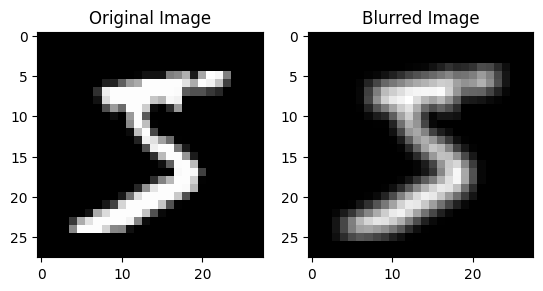

In [35]:
kernel = jnp.ones((3, 3)) # 3x3 Blur Kernel
kernel = kernel / kernel.sum()

from keras.datasets import mnist
(train_images, train_labels), (valid_images, valid_labels) = mnist.load_data()
image = train_images[0:1].astype(np.float32)
image = jnp.expand_dims(image, axis=-1)

def apply_kernel(image, kernel):
    new_image = np.zeros_like(image)
    for x in range(1,image.shape[1]-1):
        for y in range(1,image.shape[2]-1):
            new_image[:, x, y] = np.sum(image[:, x-1:x+2, y-1:y+2] * kernel[None,:,:])
    return new_image

new_image = apply_kernel(image, kernel)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image[0], cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(new_image[0], cmap='gray')
axs[1].set_title('Blurred Image')
plt.show()

## Convolutional Layers in Neural Networks

Let's implement a simple convolutional layer in JAX. Similar to the manual example above, we'll define a convolutional kernel, but this time over features. Our kernel will have shape `(in_features, height, width, out_features)`, and can be thought of as a dense layer mapping from a `(in_features, height, width)`-size matrix input to an `out_features`-size vector. 

Here, we'll visualize some basic kernels by mapping from the 1-channel grayscale space to a 3-channel RGB space.

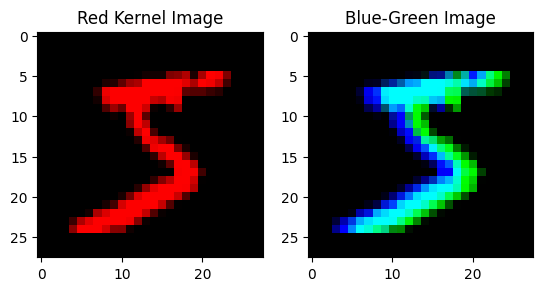

In [57]:
x = image / 255.0 # (1, 28, 28, 1)

def apply_kernel(x, kernel, stride=(1,1), padding='SAME'):
    x_t = jnp.transpose(x, (0, 3, 1, 2))
    kernel_t = jnp.transpose(kernel, (3, 0, 1, 2))
    y_t = jax.lax.conv(x_t, kernel_t, stride, padding)
    return jnp.transpose(y_t, (0, 2, 3, 1))

red_kernel = jnp.zeros((1, 3, 3, 3))
red_kernel = red_kernel.at[:, 1, 1, 0].set(1) # Map center to red.
x_red = apply_kernel(x, red_kernel)

bg_kernel = jnp.zeros((1, 3, 3, 3))
bg_kernel = bg_kernel.at[:, 1, 0, 1].set(1) # Map left-center to blue.
bg_kernel = bg_kernel.at[:, 1, 2, 2].set(1) # Map right-center to green.
x_blue_green = apply_kernel(x, bg_kernel)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x_red[0])
axs[0].set_title('Red Kernel Image')
axs[1].imshow(x_blue_green[0])
axs[1].set_title('Blue-Green Image')
plt.show()

## Stride and Padding

You'll notice that our output features have the same height/width as the input features. This symmetry is not always the case, and in fact depends on two settings.

**Stride** is the spacing between each application of the convolution kernel. In the examples above, we used a stride of `1` to keep the height/width the same. If we use a stride of `2`, the kernel will only process every *other* pixel, and our output will shrink by a factor of `2`.

**Padding** is used to dictate behavior near the edges of the images. When applying a convolutional kernel to a pixel near the edge, there are no neighboring pixels past the boundary of the image. Instead, we can use the `SAME` strategy to pad with a copy of the center pixel, or `VALID` to ignore these edge cases (reducing the output size).

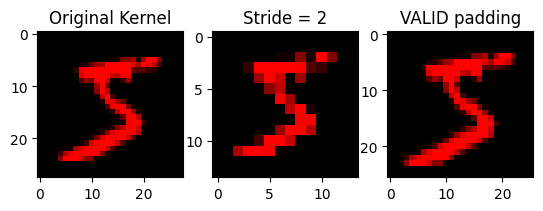

In [63]:
x_small = apply_kernel(x, red_kernel, stride=(2, 2))
x_valid = apply_kernel(x, red_kernel, padding='VALID')

fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_red[0])
axs[0].set_title('Original Kernel')
axs[1].imshow(x_small[0])
axs[1].set_title('Stride = 2')
axs[2].imshow(x_valid[0])
axs[2].set_title('VALID padding')
plt.show()

## Convolutional Neural Networks

A typical convolutional network will have a structure that first processes images with a series of convolutional layers, progressively decreasing the height/width dimension. This is achieved by using a stride greater than one. Eventually, these 2D feature maps are collapsed into a 1D vector for a series of dense layers.

In [86]:
class MyConvNet(nn.Module):

    @nn.compact
    def __call__(self, x): # Input: (B, 244, 244, 3)
        print(x.shape)
        for i in range(5):
            x = nn.Conv(features=2**(3+i), kernel_size=(3, 3), strides=(2,2))(x)
            print(x.shape)
        x = jnp.reshape(x, (x.shape[0], -1)) # (B, 15*15*128)
        print(x.shape)
        x = nn.Dense(features=10)(x)
        return x
net = MyConvNet()
params = net.init(jax.random.PRNGKey(0), jnp.zeros((1,244,244,3)))['params']
print('Parameter Kernel #4 has shape:', params['Conv_4']['kernel'].shape)

(1, 244, 244, 3)
(1, 122, 122, 8)
(1, 61, 61, 16)
(1, 31, 31, 32)
(1, 16, 16, 64)
(1, 8, 8, 128)
(1, 8192)
Parameter Kernel #4 has shape: (3, 3, 64, 128)


## Pooling Layers

Another often-employed strategy is to **pool** features by hand. Instead of using convolutional kernels with a high stride, we only use stride-1 kernels. Instead, dimensionality is reduced via **downsampling** functions.

Given a pooling patch (usually 2x2), the simplest **average pooling** strategy takes the average of these features. **Max pooling** instead takes the maximum, which can be good for identifying high-magnitude activations. Certain architectures also use image processing techniques such as **bilinear downsampling**.

Text(0.5, 1.0, 'Bilinear Downsample')

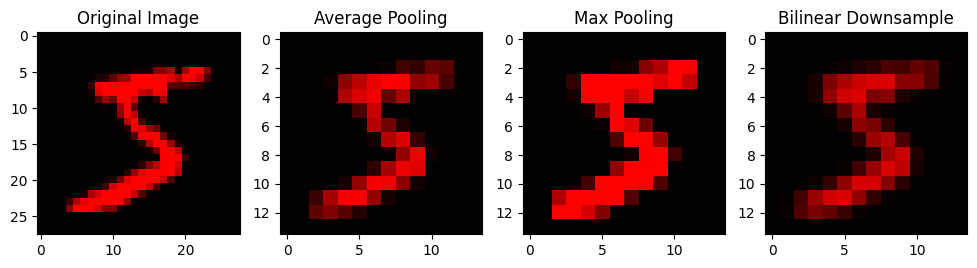

In [73]:
def average_pool(x):
    x = jnp.reshape(x, (x.shape[0], x.shape[1]//2, 2, x.shape[2]//2, 2, x.shape[3]))
    x = jnp.mean(x, axis=(2, 4))
    return x

def max_pool(x):
    x = jnp.reshape(x, (x.shape[0], x.shape[1]//2, 2, x.shape[2]//2, 2, x.shape[3]))
    x = jnp.max(x, axis=(2, 4))
    return x

def bilinear_downsample(x):
    x = jax.image.resize(x, (x.shape[0], x.shape[1]//2, x.shape[2]//2, x.shape[3]), method='bilinear')
    return x

x_average = average_pool(x_red)
x_max = max_pool(x_red)
x_bilinear = bilinear_downsample(x_red)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(x_red[0])
axs[0].set_title('Original Image')
axs[1].imshow(x_average[0])
axs[1].set_title('Average Pooling')
axs[2].imshow(x_max[0])
axs[2].set_title('Max Pooling')
axs[3].imshow(x_bilinear[0])
axs[3].set_title('Bilinear Downsample')


A typical convolutional network with downsampling:

In [87]:
class MyConvNetAvgPool(nn.Module):

    @nn.compact
    def __call__(self, x): # Input: (B, 244, 244, 3)
        print(x.shape)
        for i in range(5):
            x = nn.Conv(features=2**(3+i), kernel_size=(3, 3))(x)
            x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
            print(x.shape)
        x = jnp.reshape(x, (x.shape[0], -1)) # (B, 15*15*128)
        print(x.shape)
        x = nn.Dense(features=10)(x)
        return x
net = MyConvNet()
params = net.init(jax.random.PRNGKey(0), jnp.zeros((1,244,244,3)))['params']
print('Parameter Kernel #4 has shape:', params['Conv_4']['kernel'].shape)

(1, 244, 244, 3)
(1, 122, 122, 8)
(1, 61, 61, 16)
(1, 31, 31, 32)
(1, 16, 16, 64)
(1, 8, 8, 128)
(1, 8192)
Parameter Kernel #4 has shape: (3, 3, 64, 128)


## What problems are convolutional networks used in?

Typicaly problems with image inputs (although today, we can also use patch-embedding transformers). The key assumption in a convolutional layer is *translation-invariance*, so a convolutional network can also be used for things such as depth maps, but not for inputs that don't have local spatial structure (like a QR code).

## How are convolutional layers initialized?

The same way we would initialize a dense layer. Remember that each output feature will be a function of `(height, width, input_features)` inputs, so we should initialize the parameters with the square root of this *total* input space.

## 